In [1]:
# Check if autoreload is loaded and load/reload accordingly
try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pathlib import Path
import h5py
from copy import deepcopy

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import correlate
from scipy.integrate import solve_ivp

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'DejaVu Sans',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)


In [57]:
def chem_cond_force(xL_i, xR_i, alpha, gamma):
    return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))


def chem_strand_force(xR_a, xL_b, r_a, r_b, kappa):
    s = xL_b - xR_a
    d = r_b - r_a
    return -0.25 * kappa * d * d * ((2.0 / (s**2)) + (1.0 / ((s - d) ** 2)))

def pos_strand_force(xR_a, xL_b, r_a, r_b, kappa):
    eps = (r_b - r_a) / (xL_b - xR_a)
    return 0.25 * kappa * ((4.0 * eps) + (1.0 / ((1.0 - eps) ** 2)) - 1.)


In [58]:
4*np.pi*.15*np.power(3.*.05/(4.*np.pi), 2./3.)*(2./3.)

0.0656342903668733

[ 4.       7.       8.5     12.5      1.71875  3.28125]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3466073093234D+02   r2 =                  NaN


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59440/1573773665.py:2: RuntimeWarning: invalid value encountered in power
  return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))


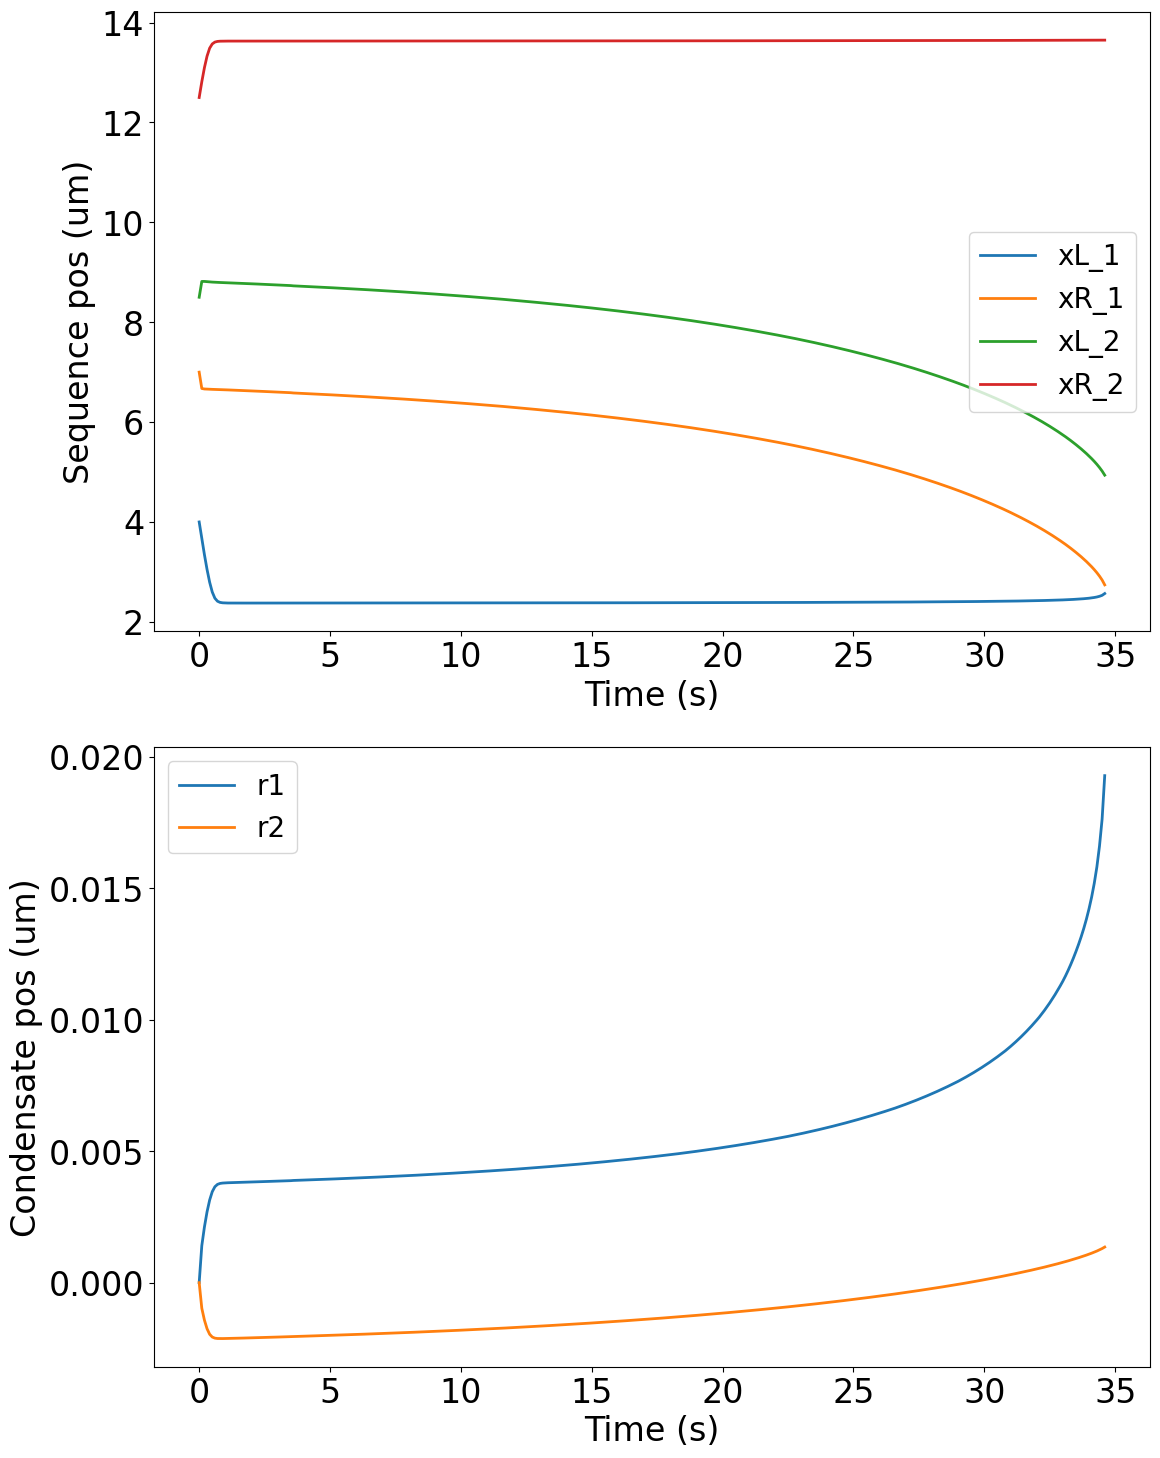

In [123]:
# Parameters
alpha = 0.205  # chemical potential (pN)
gamma = 0.0656342903668733  # surface tension term (pN.um^(1/3))
kappa = 0.0822  # strand stiffness (pN)
ko = 10.  # chemical rate constant (1/s)
b = 0.01  # segment diameter (um)
beta = 1.0 / 0.0041  # 1/(kBT) (1/pN.um)
# eta = 1.0  # viscosity (pN.um.s)
eta = 1.  # viscosity (pN.um.s)
Ltot = 1600 * b  # Contour length (um)
Ls = 5.0  # Chain end-to-end length (um)

mu0 = 1.0 / (3 * np.pi * eta)
v0 = ko * b * beta

# Init conditions
xL_1 = 400 * b
xR_1 = 700 * b
xL_2 = 850 * b
xR_2 = 1250 * b
r1 = (0.5 * (xL_1 + xR_1)) * (Ls / Ltot)
r2 = (0.5 * (xL_2 + xR_2)) * (Ls / Ltot)
x_init = np.array([xL_1, xR_1, xL_2, xR_2, r1, r2])
print(x_init)


def cond1_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_1 - xL_1) - b


def cond2_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_2 - xL_2) - b


def cond_merge(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xL_2 - xR_1) - b


cond1_dissolve.terminal = True
cond1_dissolve.direction = -1
cond2_dissolve.terminal = True
cond2_dissolve.direction = -1
cond_merge.terminal = True
cond_merge.direction = -1


def cond_system_evolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state

    dxL_1_dt = v0 * (
        -chem_cond_force(xL_1, xR_1, alpha, gamma)
        - chem_strand_force(0, xL_1, 0, r1, kappa)
    )
    dxR_1_dt = v0 * (
        chem_cond_force(xL_1, xR_1, alpha, gamma)
        + chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxL_2_dt = v0 * (
        -chem_cond_force(xL_2, xR_2, alpha, gamma)
        - chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxR_2_dt = v0 * (
        chem_cond_force(xL_2, xR_2, alpha, gamma)
        + chem_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    dr1_dt = (mu0 / (xR_1 - xL_1)) * (
        -pos_strand_force(0, xL_1, 0, r1, kappa)
        + pos_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dr2_dt = (mu0 / (xR_2 - xL_2)) * (
        -pos_strand_force(xR_1, xL_2, r1, r2, kappa)
        + pos_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    return [dxL_1_dt, dxR_1_dt, dxL_2_dt, dxR_2_dt, dr1_dt, dr2_dt]


sol = solve_ivp(
    cond_system_evolve,
    [0, 5000],
    x_init,
    method="LSODA",
    t_eval=np.arange(0, 5000, .1),
    events=[cond1_dissolve, cond2_dissolve, cond_merge],
)

# Two panel plot with x positions and r positions
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
axs[0].plot(sol.t, sol.y[0], label="xL_1")
axs[0].plot(sol.t, sol.y[1], label="xR_1")
axs[0].plot(sol.t, sol.y[2], label="xL_2")
axs[0].plot(sol.t, sol.y[3], label="xR_2")
axs[0].legend()
# axs[0].set_title("Condensate Positions")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Sequence pos (um)")  
axs[1].plot(sol.t, sol.y[4]-r1, label="r1")
axs[1].plot(sol.t, sol.y[5]-r2, label="r2")
axs[1].legend()
# axs[1].set_title("Strand Positions")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Condensate pos (um)")  
plt.tight_layout()
plt.show()



[ 2.5      5.5     10.5     14.5      1.25     3.90625]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4573264696355D+02   r2 =                  NaN


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59440/1573773665.py:2: RuntimeWarning: invalid value encountered in power
  return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))


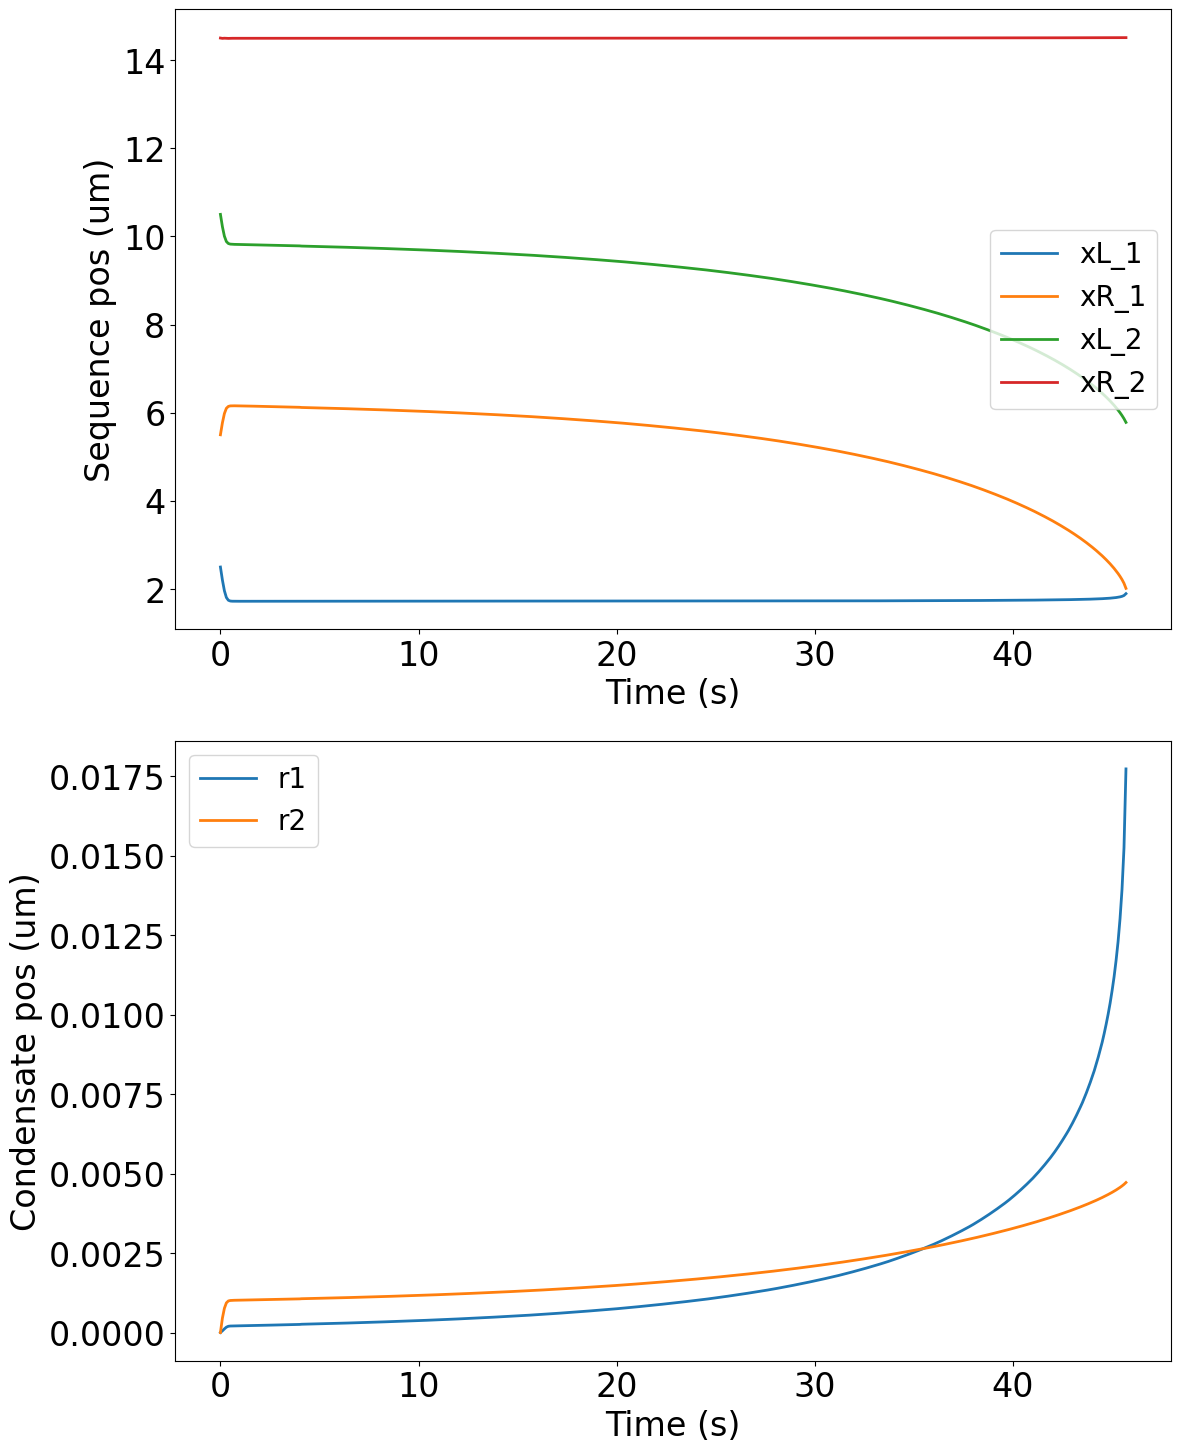

In [124]:
# Parameters
alpha = 0.205  # chemical potential (pN)
gamma = 0.0656342903668733  # surface tension term (pN.um^(1/3))
kappa = 0.0822  # strand stiffness (pN)
ko = 10.  # chemical rate constant (1/s)
b = 0.01  # segment diameter (um)
beta = 1.0 / 0.0041  # 1/(kBT) (1/pN.um)
# eta = 1.0  # viscosity (pN.um.s)
eta = 1.  # viscosity (pN.um.s)
Ltot = 1600 * b  # Contour length (um)
Ls = 5.0  # Chain end-to-end length (um)

mu0 = 1.0 / (3 * np.pi * eta)
v0 = ko * b * beta

# Init conditions
xL_1 = 250 * b
xR_1 = 550 * b
xL_2 = 1050 * b
xR_2 = 1450 * b
r1 = (0.5 * (xL_1 + xR_1)) * (Ls / Ltot)
r2 = (0.5 * (xL_2 + xR_2)) * (Ls / Ltot)
x_init = np.array([xL_1, xR_1, xL_2, xR_2, r1, r2])
print(x_init)


def cond1_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_1 - xL_1) - b


def cond2_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_2 - xL_2) - b


def cond_merge(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xL_2 - xR_1) - b


cond1_dissolve.terminal = True
cond1_dissolve.direction = -1
cond2_dissolve.terminal = True
cond2_dissolve.direction = -1
cond_merge.terminal = True
cond_merge.direction = -1


def cond_system_evolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state

    dxL_1_dt = v0 * (
        -chem_cond_force(xL_1, xR_1, alpha, gamma)
        - chem_strand_force(0, xL_1, 0, r1, kappa)
    )
    dxR_1_dt = v0 * (
        chem_cond_force(xL_1, xR_1, alpha, gamma)
        + chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxL_2_dt = v0 * (
        -chem_cond_force(xL_2, xR_2, alpha, gamma)
        - chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxR_2_dt = v0 * (
        chem_cond_force(xL_2, xR_2, alpha, gamma)
        + chem_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    dr1_dt = (mu0 / (xR_1 - xL_1)) * (
        -pos_strand_force(0, xL_1, 0, r1, kappa)
        + pos_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dr2_dt = (mu0 / (xR_2 - xL_2)) * (
        -pos_strand_force(xR_1, xL_2, r1, r2, kappa)
        + pos_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    return [dxL_1_dt, dxR_1_dt, dxL_2_dt, dxR_2_dt, dr1_dt, dr2_dt]


sol = solve_ivp(
    cond_system_evolve,
    [0, 5000],
    x_init,
    method="LSODA",
    t_eval=np.arange(0, 5000, .1),
    events=[cond1_dissolve, cond2_dissolve, cond_merge],
)

# Two panel plot with x positions and r positions
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
axs[0].plot(sol.t, sol.y[0], label="xL_1")
axs[0].plot(sol.t, sol.y[1], label="xR_1")
axs[0].plot(sol.t, sol.y[2], label="xL_2")
axs[0].plot(sol.t, sol.y[3], label="xR_2")
axs[0].legend()
# axs[0].set_title("Condensate Positions")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Sequence pos (um)")  
axs[1].plot(sol.t, sol.y[4]-r1, label="r1")
axs[1].plot(sol.t, sol.y[5]-r2, label="r2")
axs[1].legend()
# axs[1].set_title("Strand Positions")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Condensate pos (um)")  
plt.tight_layout()
plt.show()



[ 3.5      6.5      8.5     12.5      2.0625   2.78125]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2400213166267D+04   r2 =                  NaN


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59440/1573773665.py:2: RuntimeWarning: invalid value encountered in power
  return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))
/Users/alamson/local/miniconda/envs/alens_analysis/lib/python3.11/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


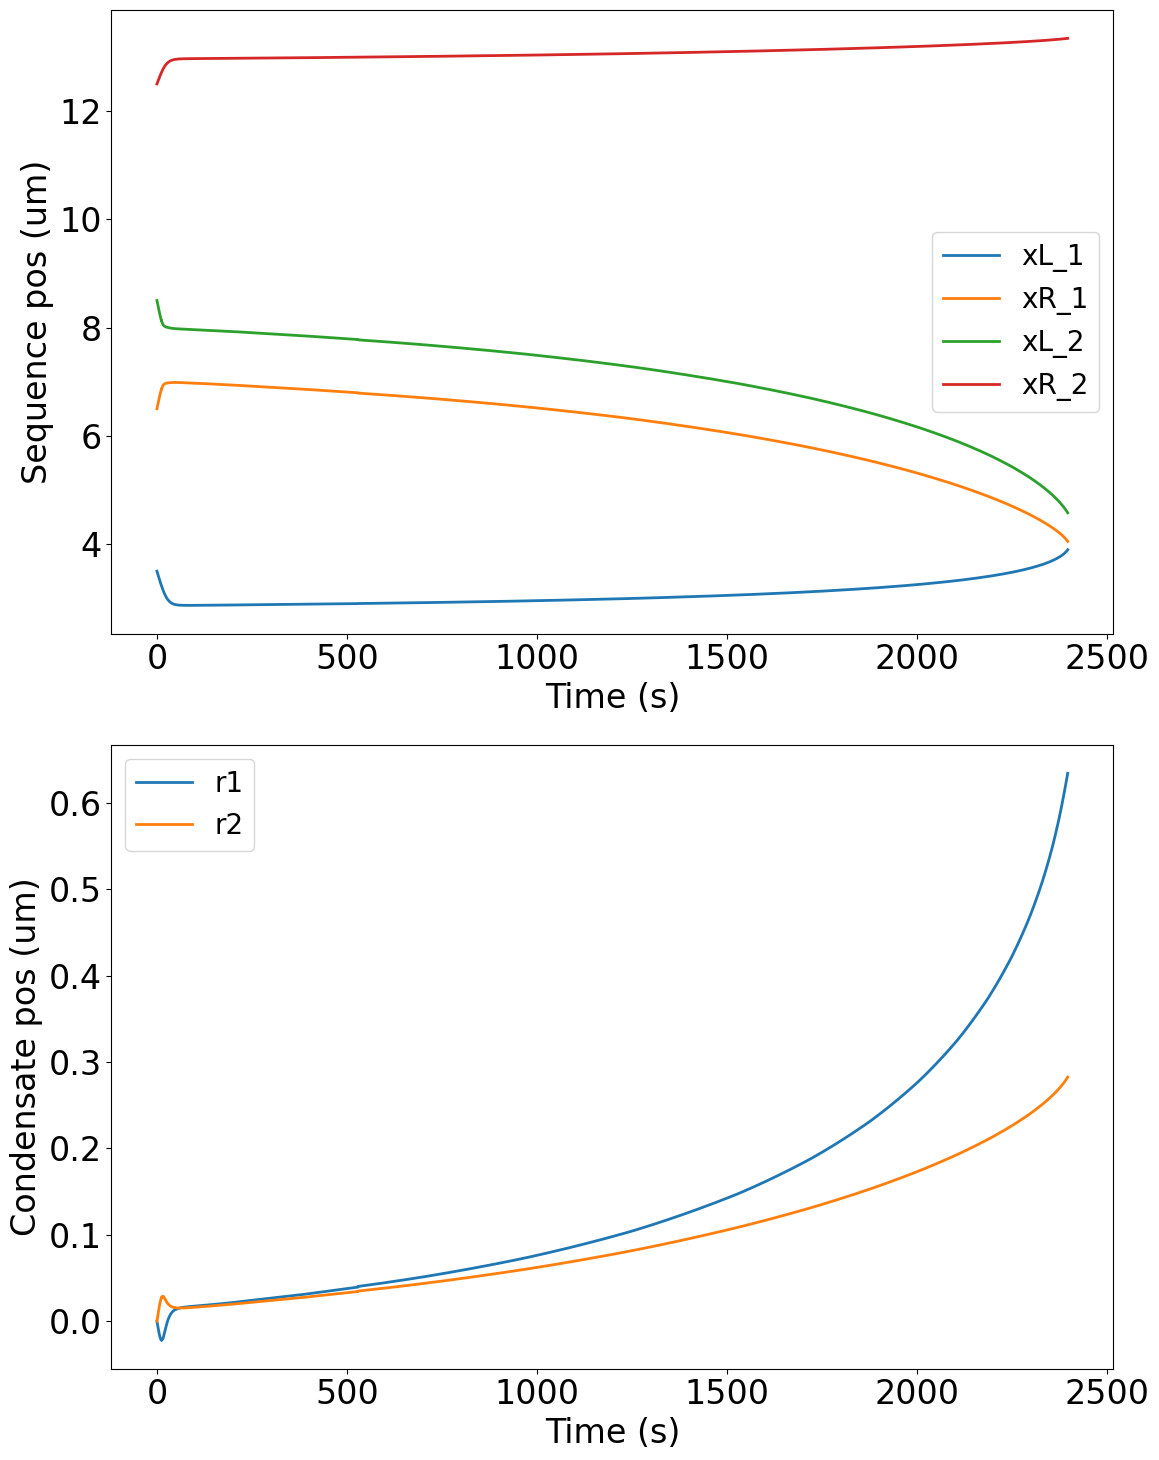

In [106]:
# Parameters
alpha = 0.205  # chemical potential (pN)
gamma = 0.0656342903668733  # surface tension term (pN.um^(1/3))
kappa = 0.0822  # strand stiffness (pN)
ko = .10  # chemical rate constant (1/s)
b = 0.01  # segment diameter (um)
beta = 1.0 / 0.0041  # 1/(kBT) (1/pN.um)
# eta = 1.0  # viscosity (pN.um.s)
eta = 1.  # viscosity (pN.um.s)
Ltot = 1600 * b  # Contour length (um)
Ls = 5.0  # Chain end-to-end length (um)

mu0 = 1.0 / (3 * np.pi * eta)
v0 = ko * b * beta

# Init conditions
xL_1 = 350 * b
xR_1 = 650 * b
xL_2 = 850 * b
xR_2 = 1250 * b
r1 = (0.5 * (xL_1 + xR_1)) * (Ls / Ltot) +.5
r2 = (0.5 * (xL_2 + xR_2)) * (Ls / Ltot)-.5
x_init = np.array([xL_1, xR_1, xL_2, xR_2, r1, r2])
print(x_init)


def cond1_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_1 - xL_1) - b


def cond2_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_2 - xL_2) - b


def cond_merge(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xL_2 - xR_1) - b


cond1_dissolve.terminal = True
cond1_dissolve.direction = -1
cond2_dissolve.terminal = True
cond2_dissolve.direction = -1
cond_merge.terminal = True
cond_merge.direction = -1


def cond_system_evolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state

    dxL_1_dt = v0 * (
        -chem_cond_force(xL_1, xR_1, alpha, gamma)
        - chem_strand_force(0, xL_1, 0, r1, kappa)
    )
    dxR_1_dt = v0 * (
        chem_cond_force(xL_1, xR_1, alpha, gamma)
        + chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxL_2_dt = v0 * (
        -chem_cond_force(xL_2, xR_2, alpha, gamma)
        - chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxR_2_dt = v0 * (
        chem_cond_force(xL_2, xR_2, alpha, gamma)
        + chem_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    dr1_dt = (mu0 / (xR_1 - xL_1)) * (
        -pos_strand_force(0, xL_1, 0, r1, kappa)
        + pos_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dr2_dt = (mu0 / (xR_2 - xL_2)) * (
        -pos_strand_force(xR_1, xL_2, r1, r2, kappa)
        + pos_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    return [dxL_1_dt, dxR_1_dt, dxL_2_dt, dxR_2_dt, dr1_dt, dr2_dt]


sol = solve_ivp(
    cond_system_evolve,
    [0, 5000],
    x_init,
    method="LSODA",
    t_eval=np.arange(0, 5000, .1),
    events=[cond1_dissolve, cond2_dissolve, cond_merge],
)

# Two panel plot with x positions and r positions
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
axs[0].plot(sol.t, sol.y[0], label="xL_1")
axs[0].plot(sol.t, sol.y[1], label="xR_1")
axs[0].plot(sol.t, sol.y[2], label="xL_2")
axs[0].plot(sol.t, sol.y[3], label="xR_2")
axs[0].legend()
# axs[0].set_title("Condensate Positions")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Sequence pos (um)")  
axs[1].plot(sol.t, sol.y[4]-r1, label="r1")
axs[1].plot(sol.t, sol.y[5]-r2, label="r2")
axs[1].legend()
# axs[1].set_title("Strand Positions")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Condensate pos (um)")  
plt.tight_layout()
plt.show()



[ 3.5      6.5      8.5     12.5      1.5625   3.28125]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1320946531657D+04   r2 =                  NaN


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59440/1573773665.py:2: RuntimeWarning: invalid value encountered in power
  return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))


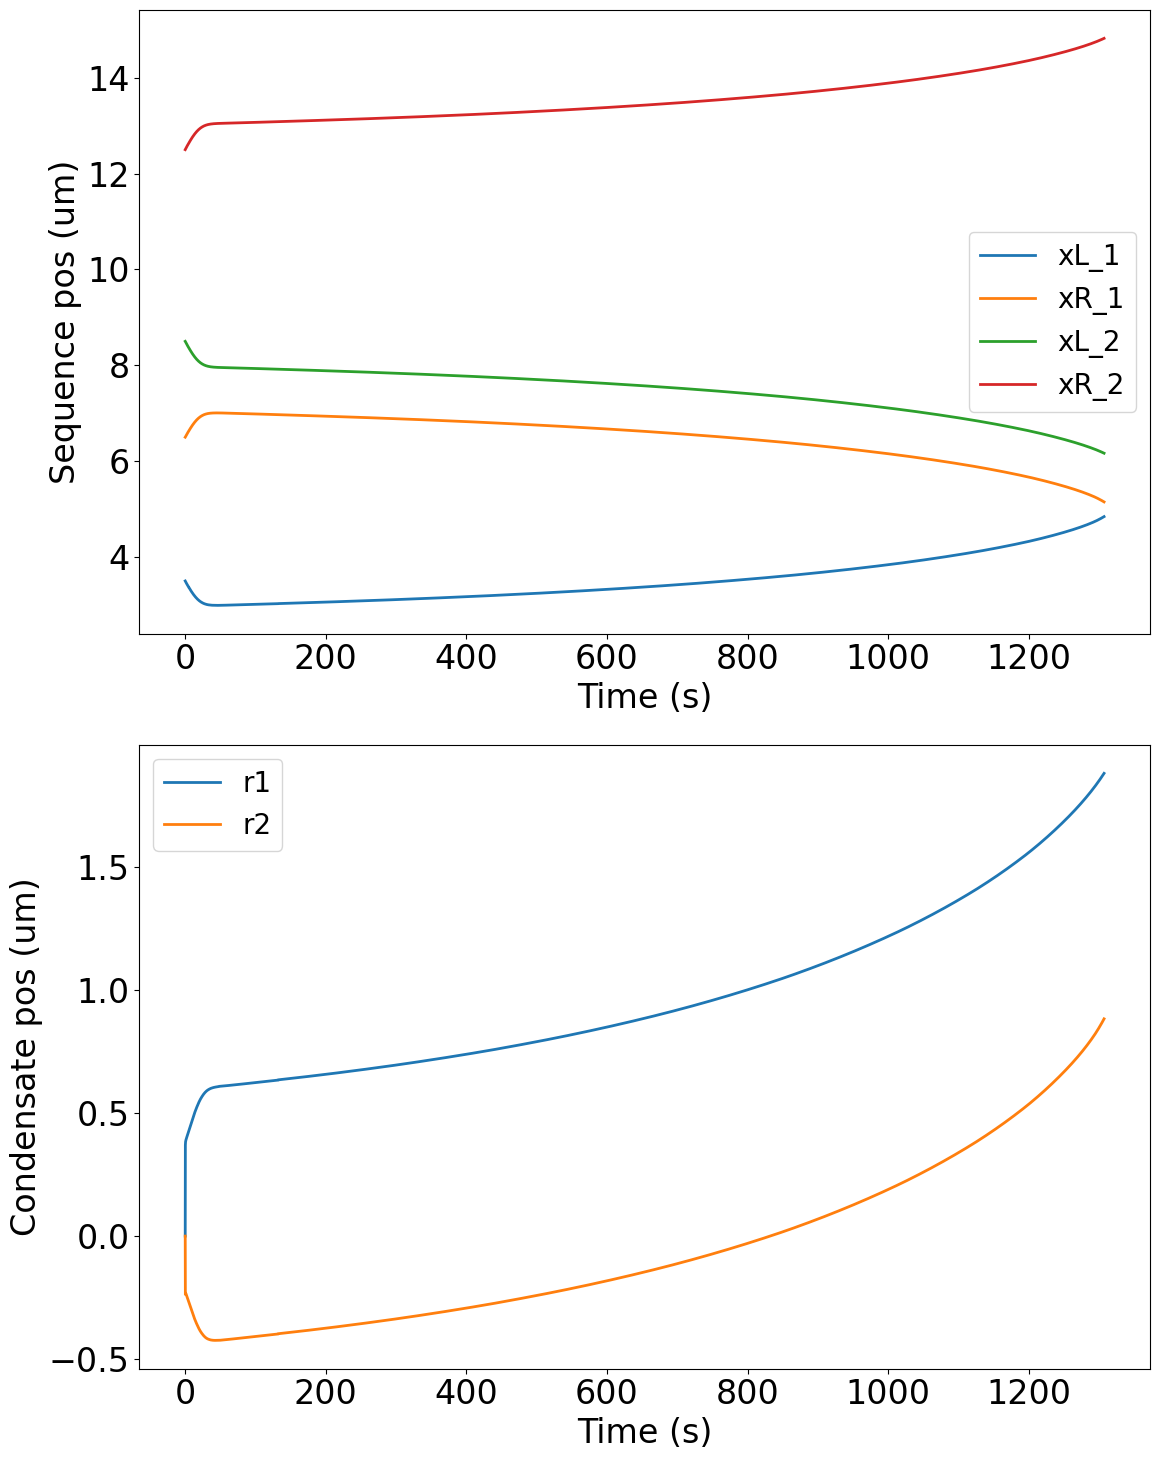

In [114]:
# Parameters
alpha = 0.205  # chemical potential (pN)
gamma = 0.0656342903668733  # surface tension term (pN.um^(1/3))
kappa = 0.0822  # strand stiffness (pN)
ko = .10  # chemical rate constant (1/s)
b = 0.01  # segment diameter (um)
beta = 1.0 / 0.0041  # 1/(kBT) (1/pN.um)
eta = .001  # viscosity (pN.um.s)
# eta = 1.0  # viscosity (pN.um.s)
Ltot = 1600 * b  # Contour length (um)
Ls = 5.0  # Chain end-to-end length (um)

mu0 = 1.0 / (3 * np.pi * eta)
v0 = ko * b * beta

# Init conditions
xL_1 = 350 * b
xR_1 = 650 * b
xL_2 = 850 * b
xR_2 = 1250 * b
r1 = (0.5 * (xL_1 + xR_1)) * (Ls / Ltot)
r2 = (0.5 * (xL_2 + xR_2)) * (Ls / Ltot)
x_init = np.array([xL_1, xR_1, xL_2, xR_2, r1, r2])
print(x_init)


def cond1_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_1 - xL_1) - b


def cond2_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_2 - xL_2) - b


def cond_merge(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xL_2 - xR_1) - b


cond1_dissolve.terminal = True
cond1_dissolve.direction = -1
cond2_dissolve.terminal = True
cond2_dissolve.direction = -1
cond_merge.terminal = True
cond_merge.direction = -1


def cond_system_evolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state

    dxL_1_dt = v0 * (
        -chem_cond_force(xL_1, xR_1, alpha, gamma)
        - chem_strand_force(0, xL_1, 0, r1, kappa)
    )
    dxR_1_dt = v0 * (
        chem_cond_force(xL_1, xR_1, alpha, gamma)
        + chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxL_2_dt = v0 * (
        -chem_cond_force(xL_2, xR_2, alpha, gamma)
        - chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxR_2_dt = v0 * (
        chem_cond_force(xL_2, xR_2, alpha, gamma)
        + chem_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    dr1_dt = (mu0 / (xR_1 - xL_1)) * (
        -pos_strand_force(0, xL_1, 0, r1, kappa)
        + pos_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dr2_dt = (mu0 / (xR_2 - xL_2)) * (
        -pos_strand_force(xR_1, xL_2, r1, r2, kappa)
        + pos_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    return [dxL_1_dt, dxR_1_dt, dxL_2_dt, dxR_2_dt, dr1_dt, dr2_dt]


sol = solve_ivp(
    cond_system_evolve,
    [0, 5000],
    x_init,
    method="LSODA",
    t_eval=np.arange(0, 5000, .1),
    events=[cond1_dissolve, cond2_dissolve, cond_merge],
)

# Two panel plot with x positions and r positions
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
axs[0].plot(sol.t, sol.y[0], label="xL_1")
axs[0].plot(sol.t, sol.y[1], label="xR_1")
axs[0].plot(sol.t, sol.y[2], label="xL_2")
axs[0].plot(sol.t, sol.y[3], label="xR_2")
axs[0].legend()
# axs[0].set_title("Condensate Positions")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Sequence pos (um)")  
axs[1].plot(sol.t, sol.y[4]-r1, label="r1")
axs[1].plot(sol.t, sol.y[5]-r2, label="r2")
axs[1].legend()
# axs[1].set_title("Strand Positions")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Condensate pos (um)")  
plt.tight_layout()
plt.show()



[ 2.5       6.5      12.       15.5       1.40625   4.296875]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1846025294366D+04   r2 =                  NaN


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59440/1573773665.py:2: RuntimeWarning: invalid value encountered in power
  return alpha - gamma * np.power(xR_i - xL_i, -(1.0 / 3.0))


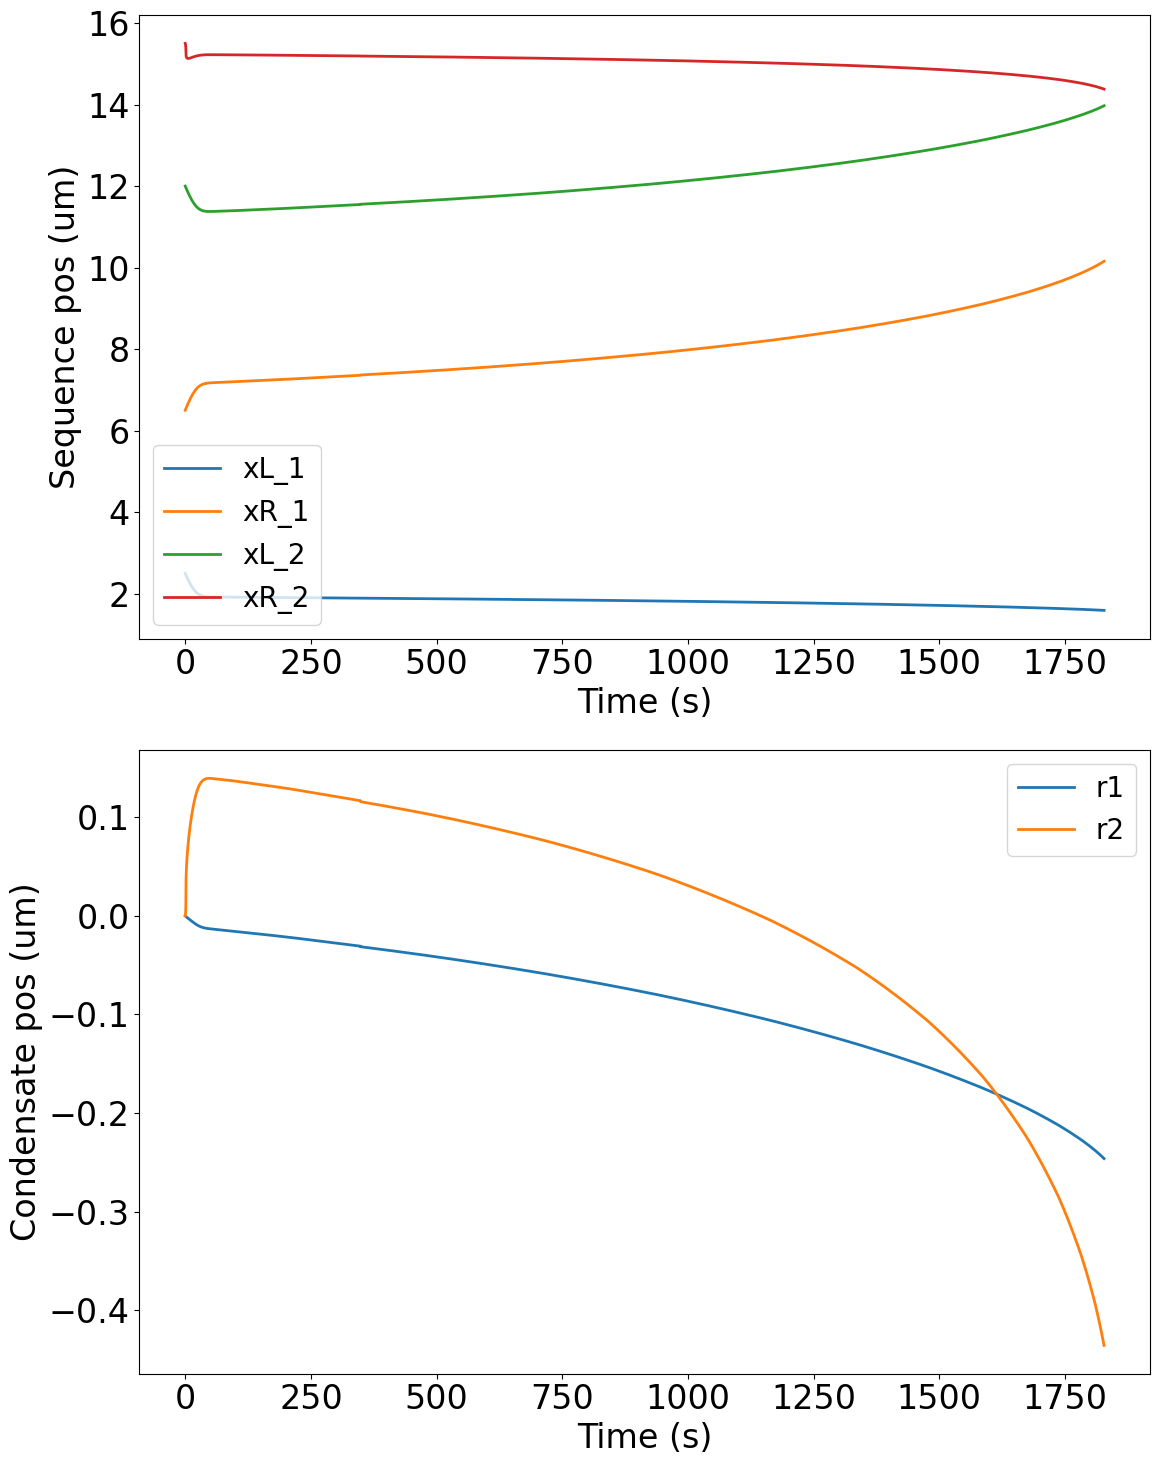

In [113]:
# Parameters
alpha = 0.205  # chemical potential (pN)
gamma = 0.0656342903668733  # surface tension term (pN.um^(1/3))
kappa = 0.0822  # strand stiffness (pN)
ko = .10  # chemical rate constant (1/s)
b = 0.01  # segment diameter (um)
beta = 1.0 / 0.0041  # 1/(kBT) (1/pN.um)
# eta = 1.0  # viscosity (pN.um.s)
eta = 1.  # viscosity (pN.um.s)
Ltot = 1600 * b  # Contour length (um)
Ls = 5.0  # Chain end-to-end length (um)

mu0 = 1.0 / (3 * np.pi * eta)
v0 = ko * b * beta

# Init conditions
xL_1 = 250 * b
xR_1 = 650 * b
xL_2 = 1200 * b
xR_2 = 1550 * b
r1 = (0.5 * (xL_1 + xR_1)) * (Ls / Ltot)
r2 = (0.5 * (xL_2 + xR_2)) * (Ls / Ltot)
x_init = np.array([xL_1, xR_1, xL_2, xR_2, r1, r2])
print(x_init)


def cond1_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_1 - xL_1) - b


def cond2_dissolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xR_2 - xL_2) - b


def cond_merge(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state
    return (xL_2 - xR_1) - b


cond1_dissolve.terminal = True
cond1_dissolve.direction = -1
cond2_dissolve.terminal = True
cond2_dissolve.direction = -1
cond_merge.terminal = True
cond_merge.direction = -1


def cond_system_evolve(t, state):
    xL_1, xR_1, xL_2, xR_2, r1, r2 = state

    dxL_1_dt = v0 * (
        -chem_cond_force(xL_1, xR_1, alpha, gamma)
        - chem_strand_force(0, xL_1, 0, r1, kappa)
    )
    dxR_1_dt = v0 * (
        chem_cond_force(xL_1, xR_1, alpha, gamma)
        + chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxL_2_dt = v0 * (
        -chem_cond_force(xL_2, xR_2, alpha, gamma)
        - chem_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dxR_2_dt = v0 * (
        chem_cond_force(xL_2, xR_2, alpha, gamma)
        + chem_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    dr1_dt = (mu0 / (xR_1 - xL_1)) * (
        -pos_strand_force(0, xL_1, 0, r1, kappa)
        + pos_strand_force(xR_1, xL_2, r1, r2, kappa)
    )
    dr2_dt = (mu0 / (xR_2 - xL_2)) * (
        -pos_strand_force(xR_1, xL_2, r1, r2, kappa)
        + pos_strand_force(xR_2, Ltot, r2, Ls, kappa)
    )
    return [dxL_1_dt, dxR_1_dt, dxL_2_dt, dxR_2_dt, dr1_dt, dr2_dt]


sol = solve_ivp(
    cond_system_evolve,
    [0, 5000],
    x_init,
    method="LSODA",
    t_eval=np.arange(0, 5000, .1),
    events=[cond1_dissolve, cond2_dissolve, cond_merge],
)

# Two panel plot with x positions and r positions
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
axs[0].plot(sol.t, sol.y[0], label="xL_1")
axs[0].plot(sol.t, sol.y[1], label="xR_1")
axs[0].plot(sol.t, sol.y[2], label="xL_2")
axs[0].plot(sol.t, sol.y[3], label="xR_2")
axs[0].legend()
# axs[0].set_title("Condensate Positions")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Sequence pos (um)")  
axs[1].plot(sol.t, sol.y[4]-r1, label="r1")
axs[1].plot(sol.t, sol.y[5]-r2, label="r2")
axs[1].legend()
# axs[1].set_title("Strand Positions")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Condensate pos (um)")  
plt.tight_layout()
plt.show()

